In [1]:
import os
import pandas as pd
import kagglehub



/guaxim/Projetos/tosh/ai/anomaly-detection/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from scipy.signal import savgol_filter
from sklearn.preprocessing import RobustScaler, StandardScaler




In [3]:
from hyperparamTuner import Trainer,DeepLearningTuner,StaticFeaturesTuner, BaseHyperParamTuner,Evaluator

--- CARREGAMENTO MANUAL DE CENÁRIOS ---
Lendo Base Normal...
Lendo Base de Falhas...
-> Adicionado: IMU_hitting_platform.csv (14967 linhas)
-> Adicionado: IMU_hitting_arm.csv (11924 linhas)
-> Adicionado: IMU_extra_weigth.csv (10885 linhas)
-> Adicionado: IMU_earthquake.csv (11409 linhas)
1. Normal processado: 874937 linhas divididas.
Falha IMU_hitting_platform.csv processado
Falha IMU_hitting_arm.csv processado
Falha IMU_extra_weigth.csv processado
Falha IMU_earthquake.csv processado
DATASET PRONTO:
-> Dados Normais: 874937 linhas
-> Dados de Falha:  24591 linhas (Total de 4 tipos de defeito)
Filtro Savitzky-Golay aplicado em 9 colunas
Filtro Savitzky-Golay aplicado em 9 colunas

Fazendo Resampling e Interpolate de IMU_10Hz.csv
Buracos gerados pelo alinhamento: 44766
Resampling concluído. Novo shape: (876347, 10)

Fazendo Resampling e Interpolate de IMU_hitting_platform.csv
Buracos gerados pelo alinhamento: 900
Resampling concluído. Novo shape: (14992, 10)
PCA:
  - Features antes : 65

In [4]:
from sklearn.mixture import GaussianMixture
import numpy as np

class GMMTrainer(Trainer):
    """GMMTrainer for anomaly detection using Gaussian Mixture Models."""

    def __init__(
        self,
        n_components: int = 2,
        covariance_type: str = "full",
        reg_covar: float = 1e-06,
        threshold_percentile: float = 5,
        **kwargs
    ) -> None:
        """
        Initializes the GMMTrainer with GMM parameters and an anomaly threshold percentile.

        Args:
            n_components: The number of mixture components.
            covariance_type: String describing the type of covariance parameters to use.
            reg_covar: Non-negative regularization added to the diagonal of covariance.
            threshold_percentile: Percentile of log-likelihoods to set as the anomaly threshold.
        """
        self.gmm = GaussianMixture(
            n_components=n_components,
            covariance_type=covariance_type,
            reg_covar=reg_covar,
            **kwargs
        )
        self.threshold: float | None = None
        self.threshold_percentile = threshold_percentile

    def TrainerFit(self, X_train: np.ndarray, Y_train: np.ndarray | None = None) -> None:
        """        Trains the GMM model and determines the anomaly threshold.

        Args:
            X_train: Normal training data.
            Y_train: Not used in this unsupervised anomaly detection method.
        """
        self.gmm.fit(X_train)
        log_likelihoods = self.gmm.score_samples(X_train)
        self.threshold = np.percentile(log_likelihoods, self.threshold_percentile)
        print(f"Anomaly threshold set at {self.threshold:.4f} (based on {self.threshold_percentile}th percentile).")

    def TrainerPred(self, X: np.ndarray) -> np.ndarray:
        """
        Predicts anomalies (0) or normal (1) for new data based on the trained GMM and threshold.

        Args:
            X: Data to classify.

        Returns:
            np.ndarray: An array of classifications (1 for normal, 0 for anomalous).
        """
        if self.threshold is None:
            raise ValueError("Model not fitted. Call TrainerFit first.")

        log_likelihoods = self.gmm.score_samples(X)
        # Classify as normal (1) if log-likelihood >= threshold, else anomalous (0)
        predictions = (log_likelihoods >= self.threshold).astype(int)
        return predictions

print("GMMTrainer class defined successfully.")

GMMTrainer class defined successfully.


In [5]:
from preprocessamento import Preprocessing
pp = Preprocessing()
pp.preprocessar_todos_deepLearning(aplicar_savgol=True, train_splits=[0.6, 0.2, 0.2], test_splits=[0.0, 0.1, 0.9], window_size=60, window_overlap=10)



Filtro Savitzky-Golay aplicado em 9 colunas
Filtro Savitzky-Golay aplicado em 9 colunas

Fazendo Resampling e Interpolate de IMU_10Hz.csv
Buracos gerados pelo alinhamento: 44766
Resampling concluído. Novo shape: (876347, 10)

Fazendo Resampling e Interpolate de IMU_hitting_platform.csv
Buracos gerados pelo alinhamento: 900
Resampling concluído. Novo shape: (14992, 10)


In [6]:
X_train = pp.normal_splits[0]
X_val = pp.normal_splits[1]
X_test = pp.normal_splits[2]

anom_val = pp.anomalo_splits[0]
anom_test = pp.anomalo_splits[1]

In [7]:
from preprocessamento import recompute_preprocessing
window_params = {
    "new_window_size": [30],
    "window_overlap": [0],
    "dimensionsPerSample": [X_train.shape[1] // pp.normal.shape[1]]
}
model_hyperparameters = {
    "n_components": [1,],
    "threshold_percentile": [0.005, 0.01,]
}

evaluator = Evaluator()

tuner = StaticFeaturesTuner(
    window_params=window_params,
    feature_engineering_fn=recompute_preprocessing(pp),
    modelTrainerParams=model_hyperparameters,
    X_train=X_train,
    X_val=X_val,
    X_test=X_test,
    anom_val=anom_val,
    anom_test=anom_test
)
tuner.tune(GMMTrainer, evaluator)

if tuner.best_params:
    print("\nBest Hyperparameters Found:")
    print(f"  Window Params: {tuner.best_params['window_params']}")
    print(f"  Model Params: {tuner.best_params['model_params']}")
    print(f"Best Validation Score: {tuner.best_score:.4f}")
else:
    print("No best parameters found.")

Processing Window Config: {'new_window_size': 30, 'window_overlap': 0, 'dimensionsPerSample': 60}
Anomaly threshold set at -831.6354 (based on 0.005th percentile).
Anomaly threshold set at -580.3782 (based on 0.01th percentile).

Best Hyperparameters Found:
  Window Params: {'new_window_size': 30, 'window_overlap': 0, 'dimensionsPerSample': 60}
  Model Params: {'n_components': 1, 'threshold_percentile': 0.005}
Best Validation Score: 1.0000


In [ ]:
window_hyperparameters = {
    "new_window_size": [30, 60],
    "window_overlap": [0, 15, 30],
    "dimensionsPerSample": [X_train.shape[1] // pp.normal.shape[1]]
}

model_hyperparameters = {
    "n_components": [1, 2, 3],
    "covariance_type": ["full", "diag"],
    "reg_covar": [1e-06, 1e-05],
    "threshold_percentile": [1, 2, 5, 10]
}

evaluator = Evaluator()

tuner = HyperParamTuner(
    windowParams=window_hyperparameters,
    modelTrainerParams=model_hyperparameters,
    X_train=X_train,
    X_val=X_val,
    X_test=X_test,
    anom_val=anom_val,
    anom_test=anom_test
)

tuner.tune(GMMTrainer, evaluator)

print("fim")

print(f"  Window Params: {tuner.best_params['window_params']}")
print(f"  Model Params: {tuner.best_params['model_params']}")
print(f"Best Validation Score: {tuner.best_score:.4f}")



Starting hyperparameter tuning...
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 2945.7951 (based on 1th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 2980.6577 (based on 2th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 3040.7031 (based on 5th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 3129.5331 (based on 10th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 2497.7219 (based on 1th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 2530.6758 (based on 2th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 2

/usr/local/lib/python3.12/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -4593.7708 (based on 2th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -4392.1140 (based on 5th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -4934.4087 (based on 10th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -4516.0175 (based on 1th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -5147.9007 (based on 2th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -4531.1279 (based on 5th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -4327.1726 (based on 10th percentile).
Training GMM

/usr/local/lib/python3.12/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -4597.0784 (based on 1th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -4277.5330 (based on 2th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -4185.0962 (based on 5th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -4090.0882 (based on 10th percentile).
Training GMM model...


/usr/local/lib/python3.12/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -4594.7512 (based on 1th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -4277.5278 (based on 2th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -4185.0799 (based on 5th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -4106.6012 (based on 10th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 1525.3815 (based on 1th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 1609.5569 (based on 2th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 1740.2562 (based on 5th percentile).
Training GMM mod

/usr/local/lib/python3.12/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -4296.6906 (based on 10th percentile).
Training GMM model...


/usr/local/lib/python3.12/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -4594.7512 (based on 1th percentile).
Training GMM model...


/usr/local/lib/python3.12/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -4564.2356 (based on 2th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -4195.7123 (based on 5th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -4106.6012 (based on 10th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 11349.6937 (based on 1th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 11349.7009 (based on 2th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 11349.7132 (based on 5th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 11349.7255 (based on 10th percentile).
Training GMM

/usr/local/lib/python3.12/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -7982.0221 (based on 5th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -8063.5472 (based on 10th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 8552.5212 (based on 1th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 8552.5628 (based on 2th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 8552.6283 (based on 5th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 8552.6911 (based on 10th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 7088.5926 (based on 1th percentile).
Training GMM mode

/usr/local/lib/python3.12/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -8635.9007 (based on 5th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -7922.8803 (based on 10th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 7875.6031 (based on 1th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 7888.5843 (based on 2th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 7907.3249 (based on 5th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 7926.4663 (based on 10th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at 6797.7947 (based on 1th percentile).
Training GMM mode

/usr/local/lib/python3.12/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -8433.9345 (based on 2th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -8366.8035 (based on 5th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -8086.2180 (based on 10th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -8551.0517 (based on 1th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -8429.9111 (based on 2th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -8582.7593 (based on 5th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -8086.2167 (based on 10th percentile).
Training GMM

/usr/local/lib/python3.12/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -7616.8782 (based on 5th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -8485.2282 (based on 10th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -9010.1695 (based on 1th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -8353.7308 (based on 2th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -8221.9570 (based on 5th percentile).
Training GMM model...
Calculating log-likelihoods for threshold determination...
Anomaly threshold set at -7906.9377 (based on 10th percentile).
Tuning complete!

Best Hyperparameters Found:
  Window Params: {'new_window_size': 30, 'window_overlap': 0, 'dimensionsPerSample': 60}
  Model Params: {'n_c

In [ ]:
from sklearn.ensemble import IsolationForest
import numpy as np

class IsolationForestTrainer(Trainer):
    """IsolationForestTrainer for anomaly detection using Isolation Forest."""

    def __init__(
        self,
        n_estimators: int = 100,
        max_samples: str | float = "auto",
        contamination: float | str = "auto",
        random_state: int | None = None,
        **kwargs
    ) -> None:
        """
        Initializes the IsolationForestTrainer with Isolation Forest parameters.

        Args:
            n_estimators: The number of base estimators in the ensemble.
            max_samples: The number of samples to draw from X to train each base estimator.
            contamination: The amount of contamination of the data set, i.e. the proportion of outliers in the data set.
            random_state: Controls the pseudo-randomness of the estimator.
            **kwargs: Additional parameters for sklearn.ensemble.IsolationForest.
        """
        self.model = IsolationForest(
            n_estimators=n_estimators,
            max_samples=max_samples,
            contamination=contamination,
            random_state=random_state,
            **kwargs
        )

    def TrainerFit(self, X_train: np.ndarray, Y_train: np.ndarray | None = None) -> None:
        """
        Trains the Isolation Forest model.

        Args:
            X_train: Normal training data.
            Y_train: Not used in this unsupervised anomaly detection method.
        """
        print("Training IsolationForest model...")
        self.model.fit(X_train)
        print("IsolationForest model trained successfully.")

    def TrainerPred(self, X: np.ndarray) -> np.ndarray:
        """
        Predicts anomalies (0) or normal (1) for new data.

        Args:
            X: Data to classify.

        Returns:
            np.ndarray: An array of classifications (1 for normal, 0 for anomalous).
        """
        raw_predictions = self.model.predict(X)
        # Convert Isolation Forest output (-1 for anomaly, 1 for normal) to Evaluator's format (0 for anomaly, 1 for normal)
        predictions = np.where(raw_predictions == 1, 1, 0)
        return predictions

print("IsolationForestTrainer class defined successfully.")

IsolationForestTrainer class defined successfully.


In [ ]:
window_hyperparameters = {
    "new_window_size": [30, 60],
    "window_overlap": [0, 15, 30],
    "dimensionsPerSample": [X_train.shape[1] // pp.normal.shape[1]]
}

model_hyperparameters = {
    "n_estimators": [50, 100, 200, 250, 300],
    "max_samples": ["auto", 0.25, 0.5, 0.75],
    "contamination": ["auto", 0.01, 0.05, 0.1],
    "random_state": [42]
}

evaluator = Evaluator()

tuner = HyperParamTuner(
    windowParams=window_hyperparameters,
    modelTrainerParams=model_hyperparameters,
    X_train=X_train,
    X_val=X_val,
    X_test=X_test,
    anom_val=anom_val,
    anom_test=anom_test
)

tuner.tune(IsolationForestTrainer, evaluator)

print(f"  Window Params: {tuner.best_params['window_params']}")
print(f"  Model Params: {tuner.best_params['model_params']}")
print(f"Best Validation Score: {tuner.best_score:.4f}")

Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained 

In [ ]:
window_hyperparameters = {
    "new_window_size": [30, 60],
    "window_overlap": [0, 15, 30],
    "dimensionsPerSample": [X_train.shape[1] // pp.normal.shape[1]]
}

model_hyperparameters = {
    "n_estimators": [200, 210, 220, 230, 240, 250],
    "max_samples": ["auto", 0.25, 0.5, 0.75],
    "contamination": ["auto", 0.01, 0.05, 0.1],
    "random_state": [42]
}

evaluator = Evaluator()

tuner = HyperParamTuner(
    windowParams=window_hyperparameters,
    modelTrainerParams=model_hyperparameters,
    X_train=X_train,
    X_val=X_val,
    X_test=X_test,
    anom_val=anom_val,
    anom_test=anom_test
)

tuner.tune(IsolationForestTrainer, evaluator)

print(f"  Window Params: {tuner.best_params['window_params']}")
print(f"  Model Params: {tuner.best_params['model_params']}")
print(f"Best Validation Score: {tuner.best_score:.4f}")

Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained successfully.
Training IsolationForest model...
IsolationForest model trained 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_autoencoder(
    window_size: int,
    n_sensors: int,
    filters: list = (32, 16),
    kernel_sizes: list = (3, 3),
    pool_size: int = 2,
    latent_channels: int = 8,
    use_batchnorm: bool = True,
):
    assert len(filters) == len(kernel_sizes)
    inp = layers.Input(shape=(window_size, n_sensors))

    # Encoder
    x = inp
    for f, k in zip(filters, kernel_sizes):
        x = layers.Conv1D(f, kernel_size=k, padding='same', activation='relu')(x)
        if use_batchnorm:
            x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=pool_size, padding='same')(x)

    # Latent
    x = layers.Conv1D(latent_channels, kernel_size=1, padding='same', activation='relu')(x)

    # Decoder
    x = layers.UpSampling1D(size=pool_size)(x)
    for f, k in zip(filters[::-1], kernel_sizes[::-1]):
        x = layers.Conv1D(f, kernel_size=k, padding='same', activation='relu')(x)
        if use_batchnorm:
            x = layers.BatchNormalization()(x)

    decoded = layers.Conv1D(n_sensors, kernel_size=1, padding='same', activation=None)(x)

    model = models.Model(inp, decoded)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')
    return model


In [ ]:
n_features_per_timestep = pp.normal.shape[1]
window_length = X_train.shape[1] // n_features_per_timestep

X_train_reshaped = X_train.reshape(-1, window_length, n_features_per_timestep)
X_val_reshaped = X_val.reshape(-1, window_length, n_features_per_timestep)
anom_val_reshaped = anom_val.reshape(-1, window_length, n_features_per_timestep)

print(f"Number of features per timestep (n_sensors): {n_features_per_timestep}")
print(f"Window length: {window_length}")
print(f"Shape of X_train_reshaped: {X_train_reshaped.shape}")
print(f"Shape of X_val_reshaped: {X_val_reshaped.shape}")
print(f"Shape of anom_val_reshaped: {anom_val_reshaped.shape}")

Number of features per timestep (n_sensors): 10
Window length: 60
Shape of X_train_reshaped: (10515, 60, 10)
Shape of X_val_reshaped: (3505, 60, 10)
Shape of anom_val_reshaped: (29, 60, 10)


**Reasoning**:
The previous step successfully reshaped the data. Now, I will build and train the CNN Autoencoder model using the reshaped training and validation data, as specified in the main task.



In [ ]:
import tensorflow as tf

cnn_autoencoder_model = build_cnn_autoencoder(
    window_size=window_length,
    n_sensors=n_features_per_timestep,
    filters=[64, 32],
    kernel_sizes=[3, 3],
    pool_size=2,
    latent_channels=8,
    use_batchnorm=True
)

cnn_autoencoder_model.fit(
    X_train_reshaped,
    X_train_reshaped,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_reshaped, X_val_reshaped),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)


Epoch 1/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 8.5848 - val_loss: 1.8467
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.9626 - val_loss: 0.5881
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.6294 - val_loss: 0.4295
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.5480 - val_loss: 0.4149
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.4336 - val_loss: 0.3597
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.4326 - val_loss: 0.3028
Epoch 7/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.3998 - val_loss: 0.2988
Epoch 8/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.3918 - val_loss: 0.2960
Epoch 9/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.4024 - val_loss: 0.2758
Epoch 10/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.3621 - val_loss: 0.2857
Epoch 11/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.3493 - val_loss: 0.2598
Epoch 12/50
329/329 ━━━━━━━━━━━━━━━━━━━

In [ ]:
print("\nEvaluating Autoencoder Reconstruction Error...")
X_val_pred = cnn_autoencoder_model.predict(X_val_reshaped)
mse_normal = np.mean(np.square(X_val_reshaped - X_val_pred), axis=(1, 2))

anom_val_pred = cnn_autoencoder_model.predict(anom_val_reshaped)
mse_anomalous = np.mean(np.square(anom_val_reshaped - anom_val_pred), axis=(1, 2))

print(f"Mean Reconstruction Error (MSE) for normal validation data: {np.mean(mse_normal):.4f}")
print(f"Mean Reconstruction Error (MSE) for anomalous validation data: {np.mean(mse_anomalous):.4f}")


Evaluating Autoencoder Reconstruction Error...
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mean Reconstruction Error (MSE) for normal validation data: 0.1445
Mean Reconstruction Error (MSE) for anomalous validation data: 14787.3740


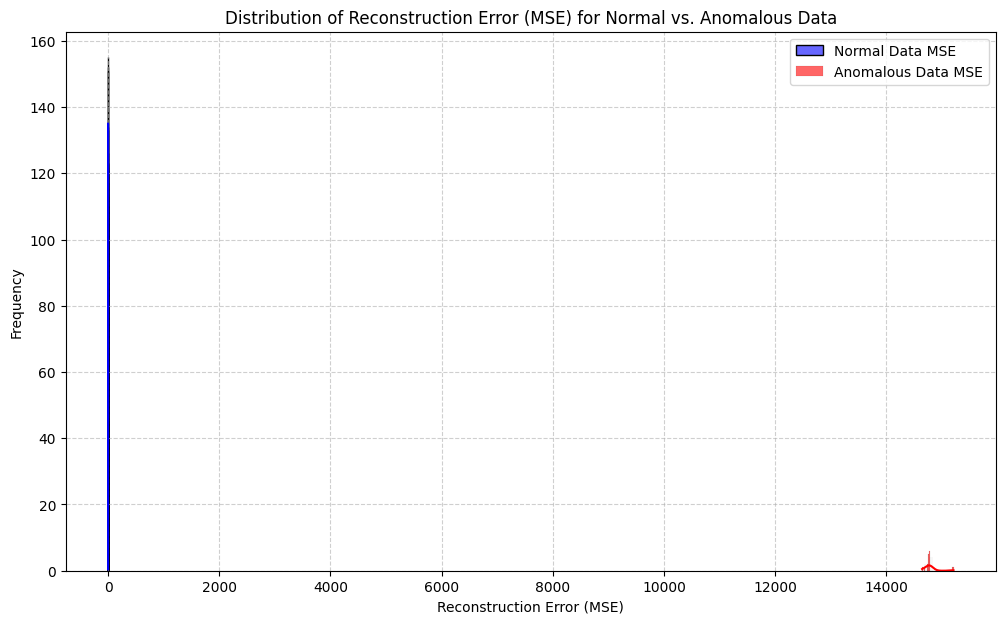


--- CNN Autoencoder Training and Evaluation Summary ---
The CNN autoencoder was trained with a window size of 60 and 10 features per timestep.
The training process aimed to minimize the Mean Squared Error (MSE) between the input and its reconstructed output, learning normal data patterns.

Evaluation on validation sets revealed the following reconstruction errors:
  - Average MSE for normal validation data: 0.1445
  - Average MSE for anomalous validation data: 14787.3740

Insights from Reconstruction Error Differences:
The histogram visualization clearly shows that the anomalous data generally exhibits higher reconstruction errors compared to the normal data. This is a crucial indicator for anomaly detection, as anomalies are deviations from learned normal patterns and thus are reconstructed less accurately, leading to larger MSE values. The model successfully distinguished between normal and anomalous patterns based on reconstruction quality.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.histplot(mse_normal, bins=50, kde=True, color='blue', label='Normal Data MSE', alpha=0.6)
sns.histplot(mse_anomalous, bins=50, kde=True, color='red', label='Anomalous Data MSE', alpha=0.6)
plt.title('Distribution of Reconstruction Error (MSE) for Normal vs. Anomalous Data')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\n--- CNN Autoencoder Training and Evaluation Summary ---")
print(f"The CNN autoencoder was trained with a window size of {window_length} and {n_features_per_timestep} features per timestep.")
print(f"The training process aimed to minimize the Mean Squared Error (MSE) between the input and its reconstructed output, learning normal data patterns.")
print(f"\nEvaluation on validation sets revealed the following reconstruction errors:")
print(f"  - Average MSE for normal validation data: {np.mean(mse_normal):.4f}")
print(f"  - Average MSE for anomalous validation data: {np.mean(mse_anomalous):.4f}")
print(f"\nInsights from Reconstruction Error Differences:")
print(f"The histogram visualization clearly shows that the anomalous data generally exhibits higher reconstruction errors compared to the normal data. This is a crucial indicator for anomaly detection, as anomalies are deviations from learned normal patterns and thus are reconstructed less accurately, leading to larger MSE values. The model successfully distinguished between normal and anomalous patterns based on reconstruction quality.")

In [ ]:
import numpy as np

anomaly_threshold = np.percentile(mse_normal, 99)

print(f"Calculated Anomaly Threshold: {anomaly_threshold:.4f}")

Calculated Anomaly Threshold (95th percentile of normal MSE): 0.3522


In [ ]:
import numpy as np

y_pred_normal = (mse_normal <= anomaly_threshold).astype(int)

y_pred_anomalous = (mse_anomalous <= anomaly_threshold).astype(int)

y_pred = np.concatenate((y_pred_normal, y_pred_anomalous))

Shape of y_pred (combined predictions): (3534,)
Predicted normal (1) samples from normal data: 3469
Predicted anomalous (0) samples from anomalous data: 29


In [ ]:
import numpy as np

y_true_normal = np.ones_like(mse_normal, dtype=int)

y_true_anomalous = np.zeros_like(mse_anomalous, dtype=int)

y_true = np.concatenate((y_true_normal, y_true_anomalous))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

print(f"\nAnomaly Detection Performance Metrics:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  AUROC: {roc_auc:.4f}")


Anomaly Detection Performance Metrics:
  Accuracy: 0.9898
  Precision: 1.0000
  Recall: 0.9897
  F1-Score: 0.9948
  AUROC: 0.9949
